In [41]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [42]:
import numpy as np
import scipy.linalg
from matplotlib.pyplot import *
import scipy.stats
import logging
from fdr import fdr_correct
#reload(logging)
#logging.basicConfig(level=logging.DEBUG)

In [43]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
#matplotlib.rc('image', cmap='RdBu_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

In [44]:
## Demean -- remove the mean from each column
demean = dm = lambda v: v-v.mean(0)

## Z-score -- z-score each column
zscore = zs = lambda v: (v-v.mean(0))/v.std(0)

## Rescale -- make each column have unit variance
rescale = rs = lambda v: v/v.std(0)

## Matrix corr -- find correlation between each column of c1 and the corresponding column of c2
mcorr = lambda c1,c2: (zs(c1)*zs(c2)).mean(0)

## Cross corr -- find corr. between each row of c1 and EACH row of c2
xcorr = lambda c1,c2: np.dot(zs(c1.T).T,zs(c2.T)) / (c1.shape[1])

# Generate data
To test things out, I'm creating a fake dataset of $M=2,000$ voxels, each with $T=1,000$ samples. Our model has $N=200$ features that are autocorrelated in time. Of the $M$ voxels, $M*Mfrac$ actually respond to the stimulus (i.e. their true beta weights are nonzero), and the other $M*(1-Mfrac)$ do not respond to the stimulus. For the responsive voxels, the true feature weights are gaussian with standard deviation `beta_sd`. For non-responsive voxels the true feature weights are all zero. The feature values, $X \in R^{T,N}$, are independent standard normal.

Responses are simulated by multiplying the features by their weights and adding noise: $Y=X \beta + \epsilon$. The standard deviation of the noise is `noise_sd`. Like the features, the noise is also autocorrelated in time.

Feature values and responses are split into regression and prediction sets so that there are $T_R=710$ time points in the regression set, and $T_P=290$ time points in the prediction set.

In [45]:
def mksmooth(rows, cols, coeff=1.0):
    """Generates data that is smooth across rows"""
    covmat = scipy.linalg.toeplitz(np.exp(-np.linspace(0, 1, rows) ** 2 / (coeff ** 2)))
    return np.random.multivariate_normal(np.zeros(rows), covmat, cols).T

Let's look at an example of a temporally autocorrelated signal generated by this function. It looks kind of like fMRI data!

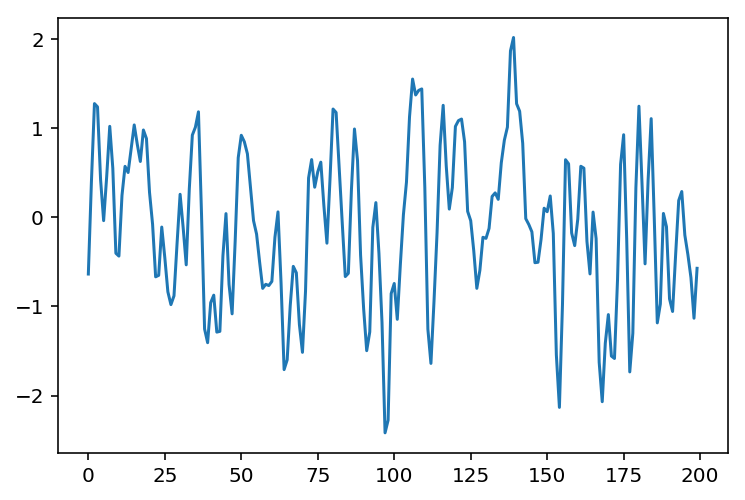

In [92]:
d = mksmooth(200,10,0.01)
plot(d[:,0])

And let's quickly visualize the timepoint-by-timepoint covariance matrix that was used to generate that data. This looks a little broader (i.e. more autocorrelated) than real fMRI data, where covariance drops to baseline outside ~10 seconds (5 TRs in our data).

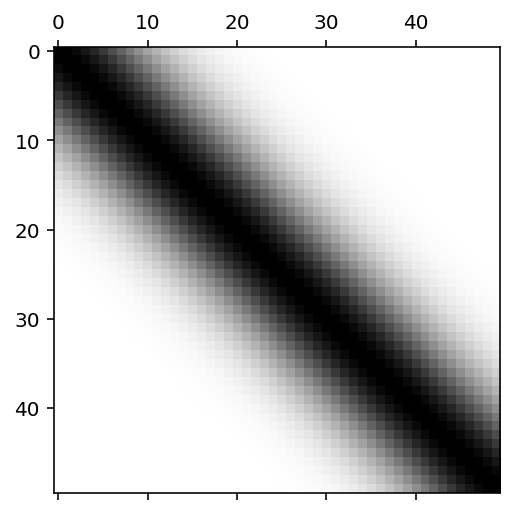

In [96]:
matshow(scipy.linalg.toeplitz(np.exp(-np.linspace(0, 1, 1000) ** 2 / (0.01 ** 2)))[:50,:50])

In [49]:
T = 1000 # number of samples
N = 200 # number of features
M = 2000 # number of responses (i.e. voxels)
Mfrac = 0.1 # fraction of responses w/ non-zero weights
noise_sd = 0.3 # noise level
beta_sd = 1.0 / np.sqrt(N) # signal level (effect size?)
trnfrac = 0.71 # fraction of data used for training

X_smoothness = 0.01
e_smoothness = 0.01

Mreal = int(M*Mfrac)

# Generate weights, features, and responses
def generate_data(T, N, M, Mfrac, noise_sd, beta_sd, trnfrac):
    beta_real = np.hstack([np.random.randn(N, int(M*Mfrac)) * beta_sd, np.zeros((N, int(M*(1-Mfrac))))])
    X = mksmooth(T, N, X_smoothness)
    Y = np.dot(X, beta_real) + noise_sd * mksmooth(T, M, e_smoothness)
    
    # Split data into regression and prediction sets
    Xr = X[:int(T*trnfrac)]
    Xp = X[int(T*trnfrac):]
    Yr = Y[:int(T*trnfrac)]
    Yp = Y[int(T*trnfrac):]

    return beta_real, X, Y, Xr, Xp, Yr, Yp

beta_real, X, Y, Xr, Xp, Yr, Yp = generate_data(T, N, M, Mfrac, noise_sd, beta_sd, trnfrac)

## Fit model using linear regression (OLS or ridge)

In [50]:
from ridge import bootstrap_ridge

def fit_and_test_model(Xr, Yr, Xp, Yp):
    # Do OLS to find beta_est
    beta_est, res, rank, sing = np.linalg.lstsq(Xr, Yr)
    
    # Predict
    Yp_est = np.dot(Xp, beta_est)

    # Get performance
    corr = mcorr(Yp, Yp_est)
    
    return beta_est, Yp_est, corr

beta_est, Yp_est, corr = fit_and_test_model(Xr, Yr, Xp, Yp)

/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


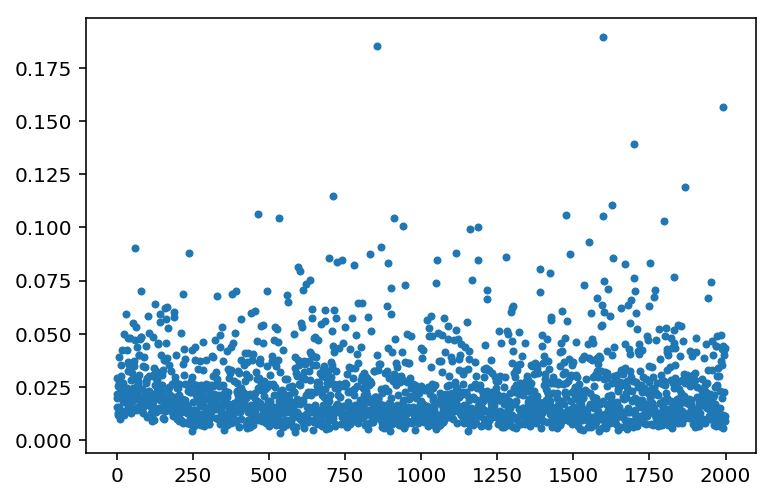

In [51]:
plot(beta_est.var(0), '.')

Let's plot the distribution of test correlations for the non-responsive voxels (gray) and responsive voxels (blue). The distribution of non-responsive correlations is a bit broader than our actual data, again suggesting that this simulation is slightly more autocorrelated.

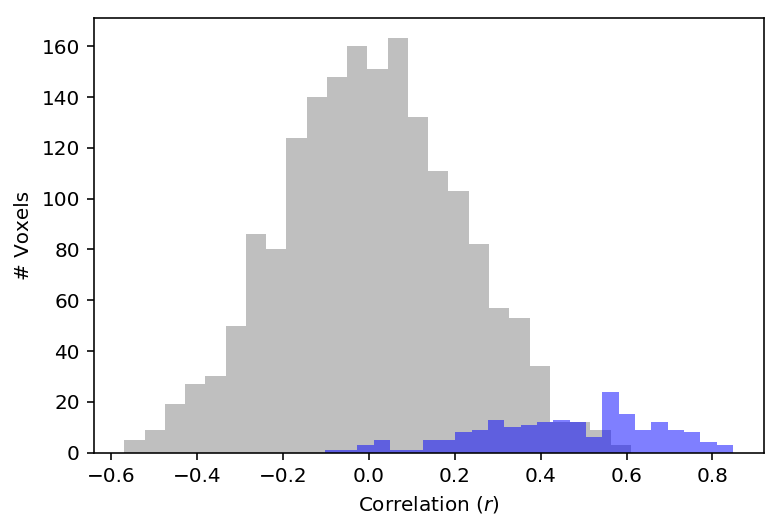

In [52]:
hist(corr[Mreal:], 25, ec='none', fc='0.5', alpha=0.5, log=False); # voxels that don't care for stimulus in gray
hist(corr[:Mreal], 25, ec='none', fc='b', alpha=0.5, log=False); # voxels that do care in blue
xlabel("Correlation ($r$)")
ylabel("# Voxels");

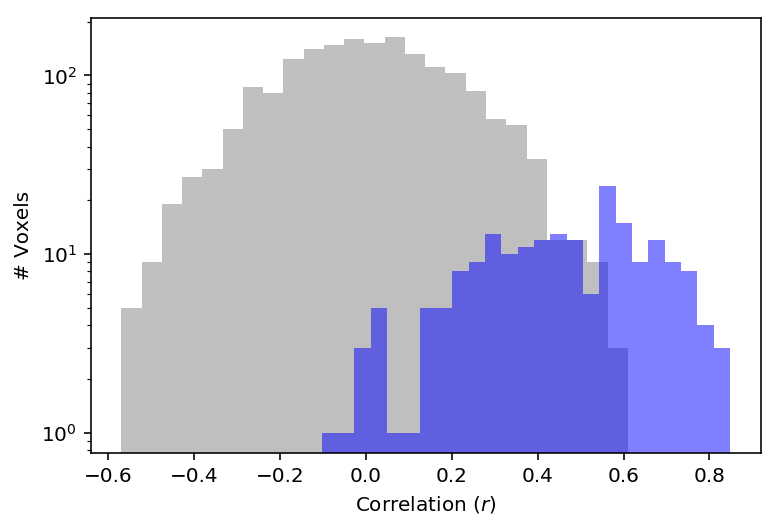

In [53]:
hist(corr[Mreal:], 25, ec='none', fc='0.5', alpha=0.5, log=True); # voxels that don't care for stimulus in gray
hist(corr[:Mreal], 25, ec='none', fc='b', alpha=0.5, log=True); # voxels that do care in blue
xlabel("Correlation ($r$)")
ylabel("# Voxels");

# Evaluate significance of prediction performance

In [54]:
from model_significance import exact_correlation_pvalue, correlation_pvalue, block_permutation_correlation, \
phase_permutation_correlation

## Method 1: Exact test (assumes Gaussianity)
When two Gaussian random variables have zero covariance, the distribution of their sample correlation coefficient, $r$, is given by [\[ref\]](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Use_the_exact_distribution):
$$f(r) = \frac{(1-r^2)^{\frac{n-4}{2}}}{B(\frac{1}{2},\frac{n-2}{2})}$$
where $B$ is the beta function and $n$ is the number of samples.

To compute a p-value we find the probability of finding a correlation at least as high as our observed correlation, $\hat{r}$, given the null distribution: 
$$P(r \ge \hat{r}) = \int_\hat{r}^1 f(r) dr$$

This method assumes that points are independent and thus that there is no autocorrelation. It should overinflate significance.

In [55]:
# For corr in units of r
exact_pvals = np.array([exact_correlation_pvalue(c, T*(1-trnfrac)) for c in corr])

## Method 2: Block permutation test

The real data (`Yp`) for each voxel is broken into overlapping blocks of length `blocklen` (20, here). Blocks are then randomly selected to construct a "permuted" timecourse, and the correlation is computed between the permuted response timecourse and real predicted timecourse (`Yp_est`). This procedure is repeated `nperms` times (10,000, here) to build a null distribution for each voxel. The permutation p-value is then computed as the fraction of null samples that are larger (i.e. more positive) than the actual correlation.

By resampling the timecourse in blocks, this test accounts for autocorrelation at scales up to the length of the block. This is OK for the simulated data, because we limited the range of autocorrelation. This is also OK for real fMRI data, where we use detrending to effectively high-pass filter the data, making sure that there is no substantial long-range autocorrelation.

In [98]:
bp_pvals = np.zeros(M)
for ii in range(M):
    true_corr = np.corrcoef(Yp[:,ii], Yp_est[:,ii])[0,1]
    perm_corrs = block_permutation_correlation(Yp[:,ii], Yp_est[:,ii], blocklen=20, nperms=10000)
    bp_pvals[ii] = (perm_corrs > true_corr).mean()

## Method 3: Phase scrambling permutation test

Another method used in the literature (e.g. Lerner et al., "Topographic mapping of a hierarchy of temporal receptive windows using a narrated story" (2011)) to generate null distributions for correlations of autocorrelated timecourses is phase randomization. In this approach, the signal is permuted by randomizing the phase of each Fourier component. This is done `nperms` (10,000, here) times to form a null distribution, and then the p-value is computed as the fraction of null samples that are greater than the actual correlation.

In [57]:
pp_pvals = np.zeros(M)
for ii in range(M):
    true_corr = np.corrcoef(Yp[:,ii], Yp_est[:,ii])[0,1]
    perm_corrs = phase_permutation_correlation(Yp[:,ii], Yp_est[:,ii], nperms=10000)
    pp_pvals[ii] = (perm_corrs > true_corr).mean()

# Compute power, FDR, and true p-value for each method
To compare these methods for computing p-values (or significance) we're computing three metrics: 
* power (i.e. the fraction of responsive voxels that are labeled significant), 
* false discovery rate (FDR; i.e. the fraction of significant voxels that are non-responsive), 
* and, as a sanity check, the actual p-value (i.e. the fraction of non-responsive voxels that are labeled significant).

We compute these metrics both for a specific desired p-value (p<0.01) and for a p-value threshold that is FDR-corrected (using the Benjamini-Hochberg procedure).

In [99]:
p = 0.01 # desired p-value

# correct p-value for FDR in each method
exact_p_fdr = fdr_correct(exact_pvals, p)[0]
bp_p_fdr = fdr_correct(bp_pvals, p)[0]
pp_p_fdr = fdr_correct(pp_pvals, p)[0]

# assign significance
exact_signif = np.array(exact_pvals) < p
bp_signif = np.array(bp_pvals) < p
pp_signif = np.array(pp_pvals) < p
fdr_exact_signif = np.array(exact_pvals) < exact_p_fdr
fdr_bp_signif = np.array(bp_pvals) < bp_p_fdr
fdr_pp_signif = np.array(pp_pvals) < pp_p_fdr

# define functions for computing power, FDR, and true p-value
power = lambda sg: sg[:Mreal].mean()
fdr = lambda sg: sg[Mreal:].sum() / sg.sum().astype(float)
truep = lambda sg: sg[Mreal:].mean()
ptest = lambda sg: scipy.stats.binom_test(sg[Mreal:].sum(), M - Mreal, p)

metrics = dict(Power=power, FDR=fdr, TrueP=truep, PvalDifference=ptest)

def print_metrics(signifs):
    for name,fun in metrics.items():
        print(name + ":")
        for methname, methvals in signifs.items():
            print("  " + methname + ":", fun(methvals))

And here we see the first real results. As expected, the Exact test (even with FDR correction) overestimates significance, giving a false discovery rate (the fraction of "significant" voxels that are false positives) of 0.69, with FDR correction and 0.72 without, and a true p-value (the fraction of non-responsive voxels that are labeled "significant") of over 0.23. 

The Phase Permutation method fares better, with a false discovery rate of 0.30 (with FDR) to 0.54 (without FDR) and a true p-value of 0.02 (with FDR) to 0.095 (without FDR). 

But the best performance here comes from the Block Permutation method, which has a false discovery rate of 0.046 (with FDR) to 0.26 (without) and true p-value of 0.0016 (with FDR) to 0.023 (without). None of these methods achieves a true p-value that is statistically indistinguishable from the desired p-value (see `PvalDifference` for the p-value of the difference), but the block permutation test comes closest.

In [113]:
print_metrics(dict(Exact=exact_signif, ExactFDR=fdr_exact_signif,
                   BlockPerm=bp_signif, BlockPermFDR=fdr_bp_signif,
                   PhasePerm=pp_signif, PhasePermFDR=fdr_pp_signif))

Power:
  Exact: 0.94
  ExactFDR: 0.915
  BlockPerm: 0.585
  BlockPermFDR: 0.31
  PhasePerm: 0.715
  PhasePermFDR: 0.49
FDR:
  Exact: 0.71898355754858
  ExactFDR: 0.6960132890365448
  BlockPerm: 0.25949367088607594
  BlockPermFDR: 0.046153846153846156
  PhasePerm: 0.5445859872611465
  PhasePermFDR: 0.30985915492957744
TrueP:
  Exact: 0.26722222222222225
  ExactFDR: 0.23277777777777778
  BlockPerm: 0.02277777777777778
  BlockPermFDR: 0.0016666666666666668
  PhasePerm: 0.095
  PhasePermFDR: 0.024444444444444446
PvalDifference:
  Exact: 0.0
  ExactFDR: 0.0
  BlockPerm: 2.255087185846887e-06
  BlockPermFDR: 4.035099714170436e-05
  PhasePerm: 7.378601979848168e-106
  PhasePermFDR: 1.4772990783264603e-07


To study how good each test is at distinguishing true from false positives, we can plot the FDR and power as a function of the p-value threshold. This is very similar to an ROC analysis: FDR (false positive rate) is plotted on the x-axis, and Power (true positive rate) on the y-axis. Curve are then obtained by choosing different p-value thresholds and computing the FDR and Power at each one. Each curve starts at the bottom left (FDR = Power = 0.0) and ends at the top right (FDR = Power = 1.0). Better tests will have "higher" curves, which give lower FDR at higher Power.

Here we see that the Exact and Block Permutation tests actually perform very similarly (albeit with different p-value thresholds). However, the Phase Permutation test performs substantially worse, giving a higher FDR at any desired Power. I suspect this is because the Phase Permutation test does not exactly preserve the set of values in the "permuted" timecourse.

/Users/huth/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


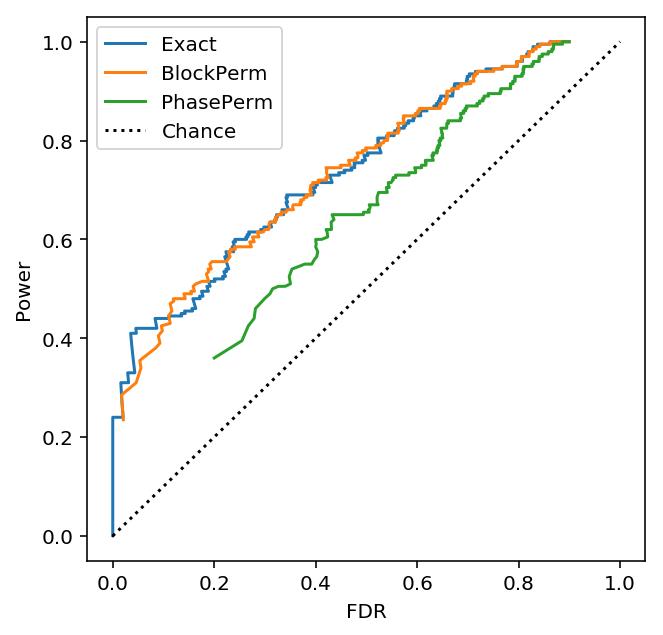

In [119]:
# plot curves as a fxn of p
pvalset = np.logspace(-50, 0, 50)
testpvals = dict(Exact=exact_pvals, BlockPerm=bp_pvals, PhasePerm=pp_pvals)
figure(figsize=(5,5))

for pvname in testpvals:
    upvals = np.unique(testpvals[pvname])
    powers = [metrics['Power'](testpvals[pvname] < p) for p in upvals]
    fdrs = [metrics['FDR'](testpvals[pvname] < p) for p in upvals]
    
    plot(fdrs, powers, label=pvname)

plot(pvalset, pvalset, 'k:', label="Chance")
legend()
xlabel("FDR")
ylabel("Power");

To study how well-calibrated each test is, we can measure the true p-value (the fraction of truly non-responsive voxels that are labeled "significant") as a function of the desired p-value. If a test was perfect, the true p-values would be identical to the desired p-values, giving a diagonal line.

Here we see that the Exact test performs very poorly, giving wildly inflated true p-values of up to 0.30, many times the desired p-value. The Phase Permutation test also performs quite poorly, although better than the Exact test. Again, the Block Permutation test performs the best, providing true p-values that are only modestly higher than the desired p-value here.

Text(0,0.5,'True p')

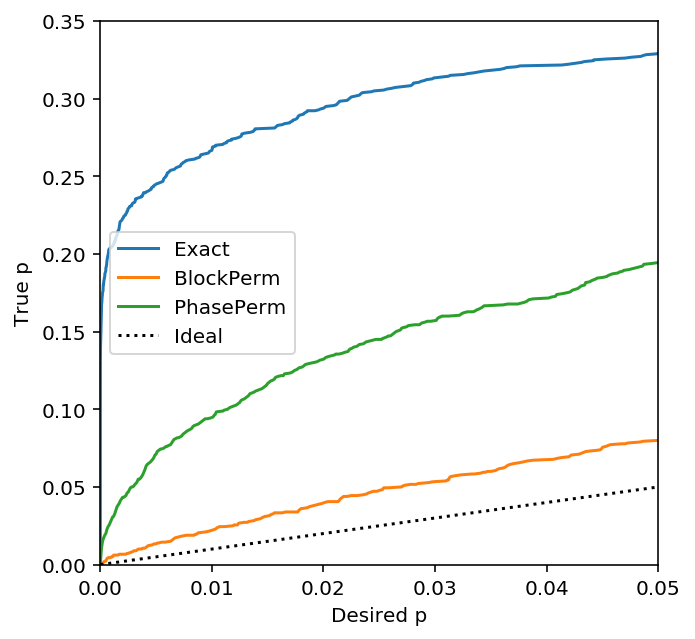

In [118]:
# plot curves as a fxn of p
pvalset = np.logspace(-5, np.log10(0.05), 50)
figure(figsize=(5,5))

for pvname in testpvals:
    truep = [metrics['TrueP'](testpvals[pvname] < p) for p in np.unique(testpvals[pvname])]
    
    plot(np.unique(testpvals[pvname]), truep, label=pvname)

plot(pvalset, pvalset, 'k:', label='Ideal')
xlim(0, 0.05)
ylim(0, 0.35)
legend()
xlabel("Desired p")
ylabel("True p")

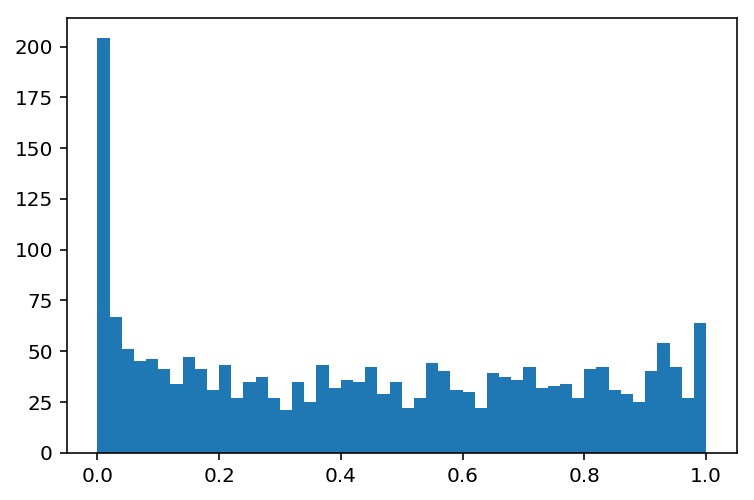

In [103]:
hist(bp_pvals, 50);

## Test with different permutation block lengths

In [60]:
def block_pvals(blocklen=10, nperms=1000):
    pvals = np.zeros(M)
    for ii in range(M):
        true_corr = np.corrcoef(Yp[:,ii], Yp_est[:,ii])[0,1]
        perm_corrs = block_permutation_correlation(Yp[:,ii], Yp_est[:,ii], blocklen=blocklen, nperms=nperms)
        pvals[ii] = (perm_corrs > true_corr).mean()
    return pvals

In [61]:
blocklens = np.unique(np.logspace(0, np.log10(51), 15).astype(int))
print(blocklens)

[ 1  2  3  4  5  7  9 12 16 21 29 38 50]


In [62]:
blocklen_pvals = [block_pvals(blocklen=bl, nperms=1000) for bl in blocklens]

In [63]:
blocklen_metrics = {name: [metric(pvals < p) for pvals in blocklen_pvals] for name,metric in metrics.items()}

Text(0.5,0,'Block Length')

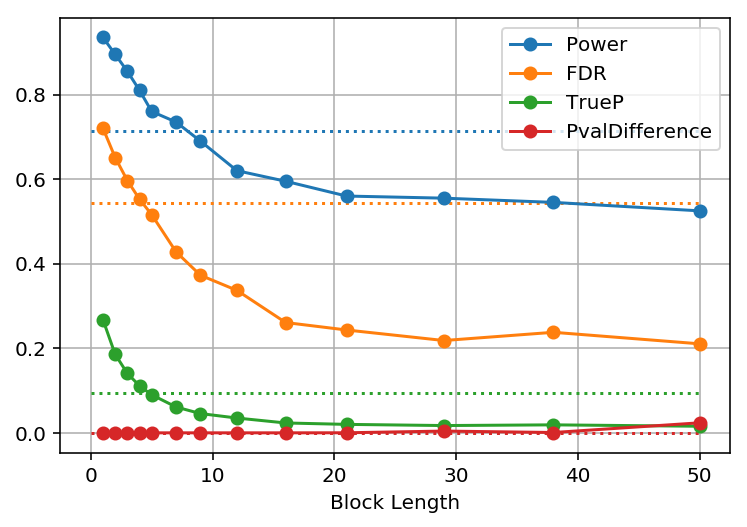

In [64]:
for name in metrics:
    line = plot(blocklens, blocklen_metrics[name], 'o-', label=name)
    hlines(metrics[name](pp_signif), 0, max(blocklens), linestyles=':', color=line[0].get_color())

legend()
grid()
xlabel("Block Length")